<a href="https://colab.research.google.com/github/gal-dmitry/HSE_DUL/blob/hw_08/Homework8_DRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 361, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 361 (delta 112), reused 90 (delta 65), pack-reused 163
Receiving objects: 100% (361/361), 55.77 MiB | 44.17 MiB/s, done.
Resolving deltas: 100% (169/169), done.
renamed 'dul_2021/Homework/hw1/data/hw1_data/geoffrey-hinton.jpg' -> 'dul_2021/Homework/hw1/data/geoffrey-hinton.jpg'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist_colored.pkl' -> 'dul_2021/Homework/hw1/data/mnist_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist.pkl' -> 'dul_2021/Homework/hw1/data/mnist.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes_colored.pkl' -> 'dul_2021/Homework/hw1/data/shapes_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes.pkl' -> 'dul_2021/Homework/hw1/data/shapes.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/smiley.jpg' -> 'dul_2021/Homework/hw1/data/smiley.jpg'
Processing ./

In [2]:
from dul_2021.utils.hw8_utils import *

# Question 1. KMM

## Notations from practice

*   $p_{nu}(x)$ - pdf of numerator
*   $p_{de}(x)$ - pdf of denominator
*   $r(x)=\frac{p_{nu}(x)}{p_{de}(x)}$ - density ratio
*   $p_{nu}^*, p_{du}^*, r^*$ - estimatinos of respective functions
*   $\{x^{nu}_i\}_{i=1}^{n_{nu}}$ - sample from numerator distribution
*   $\{x^{de}_i\}_{i=1}^{n_{de}}$ - sample from denominator distribution



## KMM objective

Here we will implement Kernel Mean Matching (KMM) method for density ratio estimation. The basic idea of KMM is to 'match' expections of kernel function:

$$argmin_{r^*} ||E_{p_{de}}r^*(x)K(\cdot, x) - E_{p_{nu}}K(\cdot, x)||$$

Where $K(x, x') = exp(-\frac{|x-y|^2}{2\sigma^2})$. Emperical variant of this objective can be rewritten as follows:

$$argmin_{r^*} \frac{1}{n_{de}^2} (r^*_{de})^t K_{de, de} r^*_{de} - \frac{2}{n_{nu}n_{de} }(r^*_{de})^t K_{de, nu}1_{n_{nu}}$$

Where


*   $r^*_{de}$ - vector with $(r^*_{de})_i=r^*(x^{de}_i)$
*   $K_{de, de}$ - matrix with $(K_{de, de})_{i, j} = K(x^{de}_i, x^{de}_j)$
*   $K_{de, nu}$ - matrix with $(K_{de, nu})_{i, j} = K(x^{de}_i, x^{nu}_j)$
*   $1_{n_{nu}}$ - vector with $n_{nu}$ ones


## You will provide these deliverables
Density ratio on $[-2, 2]$.


<Figure size 432x288 with 0 Axes>

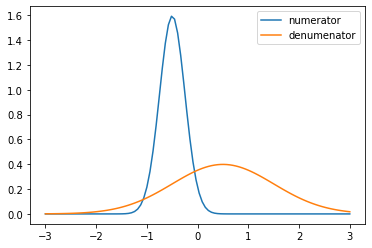

In [ ]:
# distributions

In [3]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torch.distributions import MultivariateNormal

from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
class KernelMeanMatchDRE(nn.Module):
    def __init__(self, hd=128):
        super().__init__()
        # self.sigma = 1
        # self.sigma = 2
        # self.sigma = 0.5
        self.sigma = 0.25

        self.r = nn.Sequential(nn.Linear(1, hd), 
                               nn.ReLU(),
                               nn.Linear(hd, hd), 
                               nn.ReLU(),
                               nn.Linear(hd, 1),
                               nn.Softplus())
    
    def fit(self, data_nu, data_de, batch_size=512, lr=1e-3, num_epochs=1000):
     
        loader_nu = DataLoader(data_nu, 
                               batch_size=batch_size, 
                               shuffle=True)
        
        loader_de = DataLoader(data_de, 
                               batch_size=batch_size, 
                               shuffle=True)
        
        optim = Adam(self.r.parameters(), lr=lr)

        for epoch in tqdm(range(num_epochs)):
            for (batch_nu, batch_de) in zip(loader_nu, loader_de):
                batch_nu = batch_nu.view(-1, 1).float()
                batch_de = batch_de.view(-1, 1).float()

                n_nu = batch_nu.shape[0]
                n_de = batch_de.shape[0]

                r_nu = torch.ones_like(batch_nu)
                r_de = self.r(batch_de)

                K_de_nu = self.get_K_de_nu(batch_de, batch_nu)
                K_de_de = self.get_K_de_de(batch_de)

                right = 2 * (r_de.T @ K_de_nu @ r_nu) / (n_de * n_nu)
                left = (r_de.T @ K_de_de @ r_de) / ((n_de)**2)

                loss = left - right

                optim.zero_grad()
                loss.backward()
                optim.step()


    def get_K_de_nu(self, batch_de, batch_nu):
        K = -(-2*(batch_de @ batch_nu.T) + batch_de**2 + batch_nu.T**2) / (2 * self.sigma**2)
        return torch.exp(K)


    def get_K_de_de(self, batch_de):
        K = -(-2*(batch_de @ batch_de.T) + batch_de**2 + batch_de.T**2) / (2 * self.sigma**2)
        return torch.exp(K)

In [ ]:
def q1(data_nu, data_de):
    """
    data_nu - An [n_nu] dataset with samples from numerator's distribution
    data_de - An [n_de] dataset with samples from denominators's distribution

    Returns
    - a np.array with density ratios of np.linspace(-2., 2, num=100)
    """
    # your code goes here
    # you need to calculate density ratio on x and return it
    # x = np.linspace(-2., 2, num=100)

    model = KernelMeanMatchDRE()
    model.fit(data_nu, data_de)    

    with torch.no_grad():
        x = np.linspace(-2., 2, num=100)        
        ratio_pred = model.r(torch.FloatTensor(x.reshape(-1, 1))).cpu().numpy()

    return ratio_pred

  0%|          | 0/1000 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

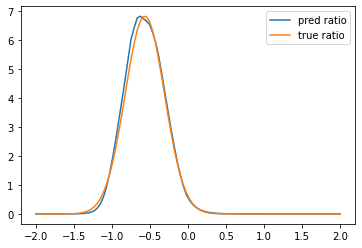

In [ ]:
q1_results(q1)

# Question 2. AVB

Here we will implement [Adversairal Variational Bayes](https://dl.acm.org/doi/pdf/10.5555/3305890.3305928).

You may experiment with different hyperparameters and architecture designs, but the following designs for the AVB architecture may be useful.

```
Classifier (T)
    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(),
    # reshape + add latent
    Linear(4 * 4 * 128 + ld, hd), 
    ReLU(),
    Linear(hd, hd), 
    ReLU(),
    Linear(hd, 1)


Encoder (E)

    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(), 
    # add noise + reshape
    Linear(4 * 4 * 128 + nd, ld)

Decoder (D)
    ConvTranspose2d(128, 128, 3, 2, 1), 
    ReLU(), 
    ConvTranspose2d(128, 64, 4, 2, 1), 
    ReLU(), 
    ConvTranspose2d(64, 32, 4, 2, 1), 
    ReLU(), 
    Conv2d(32, 1, 3, 1, 1)
    # reshape
    Linear(ld, 4 * 4 * 128), 
    ReLU()
```

**Reminder.** Objective for AVB

$$max_{\theta, \phi} E \log p_\theta(x|z_\phi(x)) - T(x, z_\phi(x))$$
$$max_{T} E_x \bigg(E_{q_\phi(z|x)} \log\big(\sigma (T(x, z))\big) + E_{p(z)} \log\big(1 - \sigma (T(x, z))\big)\bigg) $$

$\phi$ - parameters of encoder, $\theta$ - parameters of decoder


**You will provide the following deliverables**


1.   Over the course of training, record the elbo and loss of the classifier T ber batch.
2. Report the final test set performances of your final models
3. 100 samples from your trained AVB

In [26]:
class Classifier(nn.Module):

    def __init__(self, latent_dim=1, hidden_dim=128):
        super().__init__()
        self.conv_block = nn.Sequential(nn.Conv2d(1, 32, 3, 1, 1),
                                        nn.ReLU(),
                                        nn.Conv2d(32, 64, 3, 2, 1),
                                        nn.ReLU(), 
                                        nn.Conv2d(64, 128, 3, 2, 1), 
                                        nn.ReLU(), 
                                        nn.Conv2d(128, 128, 3, 2, 1), 
                                        nn.ReLU())

        self.linear_block = nn.Sequential(nn.Linear(4 * 4 * 128 + latent_dim, hidden_dim), 
                                          nn.ReLU(),
                                          nn.Linear(hidden_dim, hidden_dim), 
                                          nn.ReLU(),
                                          nn.Linear(hidden_dim, 1))
  
    def forward(self, x, z):
        out = self.conv_block(x)
        out = torch.cat((torch.flatten(out, start_dim=1), z), dim=1)
        out = self.linear_block(out)
        return out



class Encoder(nn.Module):

    def __init__(self, latent_dim=1, noise_dim=1):
        super().__init__()
        self.conv_block = nn.Sequential(nn.Conv2d(1, 32, 3, 1, 1),
                                        nn.ReLU(),
                                        nn.Conv2d(32, 64, 3, 2, 1),
                                        nn.ReLU(), 
                                        nn.Conv2d(64, 128, 3, 2, 1), 
                                        nn.ReLU(), 
                                        nn.Conv2d(128, 128, 3, 2, 1), 
                                        nn.ReLU())

        self.linear_block = nn.Linear(4 * 4 * 128 + noise_dim, latent_dim)

    def forward(self, x, noise):
        batch_size = x.shape[0]
        out = self.conv_block(x)
        out = torch.cat((torch.flatten(out, start_dim=1), noise), dim=1)
        out = self.linear_block(out)
        return out



class Decoder(nn.Module):

    def __init__(self, latent_dim=1):
        super().__init__()
        self.linear_block = nn.Sequential(nn.Linear(latent_dim, 4 * 4 * 128),
                                          nn.ReLU())

        self.conv_transposed_block = nn.Sequential(nn.ConvTranspose2d(128, 128, 3, 2, 1), 
                                                   nn.ReLU(), 
                                                   nn.ConvTranspose2d(128, 64, 4, 2, 1), 
                                                   nn.ReLU(), 
                                                   nn.ConvTranspose2d(64, 32, 4, 2, 1), 
                                                   nn.ReLU(), 
                                                   nn.Conv2d(32, 1, 3, 1, 1))
  
    def forward(self, x):
        batch_size = x.shape[0]
        out = self.linear_block(x)
        out = out.reshape(batch_size, 128, 4, 4)
        out = self.conv_transposed_block(out)
        return out

In [15]:
class AVB(nn.Module):
    
    def __init__(self, latent_dim=32, noise_dim=32, hidden_dim=128):
        super().__init__()

        self.clf = Classifier(latent_dim=latent_dim, hidden_dim=hidden_dim)
        self.enc = Encoder(latent_dim=latent_dim, noise_dim=noise_dim)
        self.dec = Decoder(latent_dim=latent_dim)

        self.latent_dist = MultivariateNormal(
            torch.zeros(latent_dim, device=device),
            torch.eye(latent_dim, device=device)
        )

        self.noise_dist = MultivariateNormal(
            torch.zeros(noise_dim, device=device),
            torch.eye(noise_dim, device=device)
        )
    

    def calculate_loss(self, x):
        '''elbo loss'''
        batch_size = x.shape[0]
        
        noise = self.noise_dist.sample((batch_size,))
        z_enc = self.enc(x, noise)
        x_rec = self.dec(z_enc)

        rec_loss = F.mse_loss(x, x_rec, reduction='none').reshape(batch_size, -1).sum(dim=1)
        clf_loss = self.clf(x, z_enc)
        elbo_loss = rec_loss + clf_loss

        '''clf loss'''
        with torch.no_grad():
            noise = self.noise_dist.sample((batch_size,))
            z_enc = self.enc(x, noise)
        z_random = self.latent_dist.sample((batch_size,))

        clf_real = torch.sigmoid(self.clf(x, z_enc))
        clf_fake = torch.sigmoid(self.clf(x, z_random))

        clf_real_loss = F.binary_cross_entropy(clf_real, torch.ones_like(clf_real))
        clf_fake_loss = F.binary_cross_entropy(clf_fake, torch.zeros_like(clf_fake))
        clf_loss = clf_real_loss + clf_fake_loss

        return elbo_loss.mean(), clf_loss.mean()
    

    @torch.no_grad()
    def test(self, test_loader):
        total_elbo_loss = 0
        total_clf_loss = 0
        n = 0
        for batch in test_loader:
            batch = batch.to(device)
            batch_size = batch.shape[0]

            elbo_loss, clf_loss = self.calculate_loss(batch)
            total_elbo_loss += batch_size * elbo_loss
            total_clf_loss += batch_size * clf_loss
            n += batch_size

        return [total_elbo_loss.item() / n, total_clf_loss.item() / n]


    @torch.no_grad()
    def sample(self, n_samples=100):
        z = self.latent_dist.sample((n_samples,))
        samples = self.dec(z) 
        images = 0.5 * samples.clip(-1, 1) + 0.5
        return images.cpu().numpy()


    def fit(self, train_loader, test_loader, epochs=20, lr=1e-3):

        train_losses = []
        test_losses = []

        elbo_opt = Adam(list(self.enc.parameters()) + list(self.dec.parameters()), lr=lr)
        clf_opt = Adam(self.clf.parameters(), lr=lr)

        test_losses.append(self.test(test_loader))

        for epoch in trange(epochs, desc="Fit"):
            for batch in tqdm(train_loader, desc="Batch", leave=False):

                batch = batch.to(device)
                elbo_loss, clf_loss = self.calculate_loss(batch)

                elbo_opt.zero_grad()
                elbo_loss.backward()
                elbo_opt.step()

                clf_opt.zero_grad()
                clf_loss.backward()
                clf_opt.step()

                train_losses.append([elbo_loss.item(), clf_loss.item()])
            test_losses.append(self.test(test_loader))
          
        return np.array(train_losses), np.array(test_losses)


In [16]:
class CustomDataset(Dataset):
    def __init__(self, images):
        super().__init__()

        images = torch.tensor(images.transpose(0, 3, 1, 2),
                              dtype=torch.float32)

        self.images = 2*images - 1

    def __len__(self):
        return self.images.size(0)

    def __getitem__(self, idx):
        return self.images[idx]

In [29]:
def q2(train_data, test_data):
    """
    train_data - A (n_train, 28, 28, 1) uint8 numpy array of binary images with values in {0, 1}
    Returns
    - a (# of training iterations,) numpy array of elbo_losses evaluated every minibatch
    - a (# of training iterations,) numpy array of classifier_losses evaluated every minibatch
    - a torch tensor of size (100, 1, 28, 28) of samples with values in {0, 1}
    """

    n_samples = 100
    batch_size = 256
    epochs = 20
    # epochs = 2
    lr = 1e-3

    latent_dim = 64
    noise_dim = 5
    hidden_dim = 128
    
    train_loader = DataLoader(CustomDataset(train_data), 
                              batch_size=batch_size, 
                              shuffle=True)
    
    test_loader = DataLoader(CustomDataset(test_data), 
                             batch_size=batch_size, 
                             shuffle=True)
    
    model = AVB(latent_dim, noise_dim, hidden_dim).to(device)

    train_losses, test_losses = model.fit(train_loader, test_loader, epochs, lr)
    elbo_train_losses, clf_train_losses = train_losses[:, 0], train_losses[:, 1]
    elbo_test_losses, clf_test_losses = test_losses[:, 0], test_losses[:, 1]

    samples = model.sample(n_samples=n_samples)

    return elbo_train_losses, clf_train_losses, elbo_test_losses, clf_test_losses, samples

Fit:   0%|          | 0/20 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

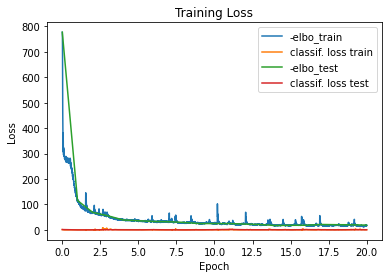

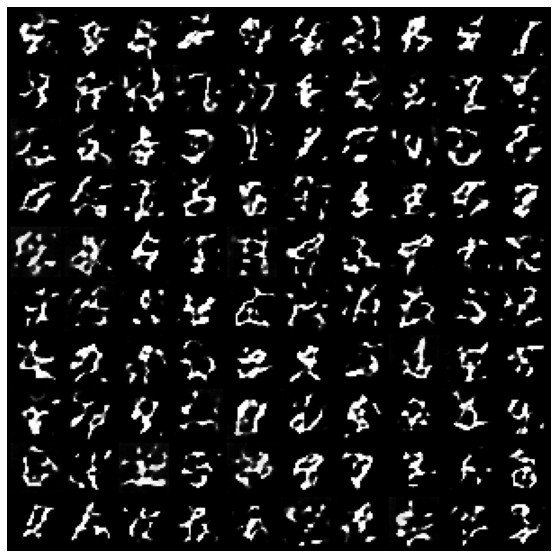

In [30]:
q2_results(q2)

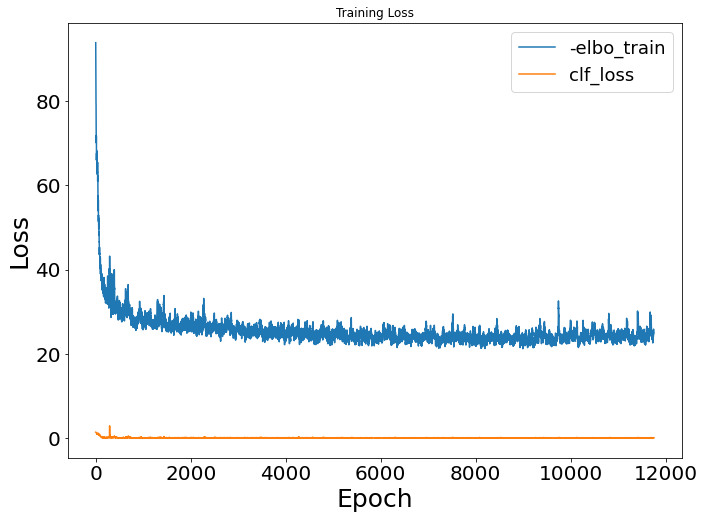

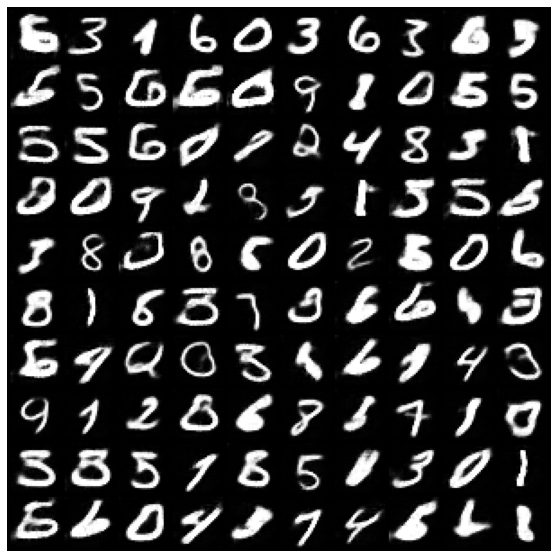

In [ ]:
# original
q2_results(q2)